# Individual Planning Report

#### **Predicting Newsletter Subscriptions from Player Behaviour and Characteristics in a Minecraft Server**



### 1. Research Question

Based on the data and research approaches, this project will try to answer the following broad question: 

*Question 1*: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

From that, a specific question was formulated:

Based on their experience level, hours played, age, and gender, can we predict whether a player will subscribe to the game-related newsletter?


In [1]:
library(tidyverse)
library(tidymodels)
library(GGally)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Understanding player engagement and behaviour is important for maintaining an active community in online games. Subscribing to a newsletter indicates a higher interest and long-term involvement from the player. By analyzing Frank Wood's `player` dataset from their Minecraft server, we can identify which characteristics and behaviours are most useful to predict the likelihood of players subscribing to a newsletter. These insights can help server administrators or game developers design better communication strategies.


In [2]:
# load the dataset and get the header
players <- read_csv("/home/jovyan/work/individual_planning_report/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### 2. Data Description

The dataset, `players`, includes 196 observations and the following 7 variables:

`experience`: Categrorical measure of player’s experience level in the game

`subscribe`: Whether the player subscribed to the newsletter (TRUE/FALSE) → *Target variable*

`hashedEmail`: Player email (excluded for privacy reasons)

`played_hours`: Total hours the player has spent on the server

`name`: Player name (excluded from analysis)

`gender`: Player’s self-identified gender

`age`: Player’s age in years

Below is the data with initial wrangling and a statistical summary of the predictive variables.


In [7]:
# do initial wrangling for intended analysis
tidy_players <- players|>
        mutate(subscribe = as_factor(subscribe), age = Age) |>
        select(experience, subscribe, played_hours, gender, age) 
head(tidy_players)

# create tibble with summary statistics
players_summary <- tibble(
    # calculate the age mean
    mean_age = tidy_players |>
    summarise(mean_age = mean(age, na.rm = TRUE)) |>
    pull(mean_age), 

    # calculate the played hours mean
    mean_played_hours = tidy_players |>
    summarise(mean_played_hours = mean(played_hours, na.rm = TRUE)) |>
    pull(mean_played_hours),   

    # calculate the age median
    median_age = tidy_players |>
    summarise(median_age = median(age, na.rm = TRUE)) |>
    pull(median_age),

    # calculate the played hours median
    median_played_hours = tidy_players |>
    summarise(median_played_hours = median(played_hours, na.rm = TRUE)) |>
    pull(median_played_hours),

    # find the experience mode
    mode_experience = tidy_players |>
    count(experience) |>
    slice_max(n, n = 1) |>
    pull(experience),

    # find the gender mode
    mode_gender = tidy_players |>
    count(gender) |>
    slice_max(n, n = 1) |>
    pull(gender))

players_summary


experience,subscribe,played_hours,gender,age
<chr>,<fct>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.0,Female,17


mean_age,mean_played_hours,median_age,median_played_hours,mode_experience,mode_gender
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
21.13918,5.845918,19,0.1,Amateur,Male


#### **Potential Data Issues**

*Sample Size*:
With only 196 observations, the dataset is relatively small, which may limit model complexity and ability to generalize.

*Missing Values*:
Some players might not have reported certain information (e.g., age or gender), requiring either imputation or removal of incomplete rows.

*Imbalanced Classes*:
Certain variables are imbalanced (one label is significantly more frequent than another), the model may become biased toward predicting the majority class. 

*Measurement Errors*:
The variable `played_hours` might have been measured inconsistently (a lot of observations record 0.0 hours played), potentially introducing noise.

*Data Collection Bias*:
The dataset may only include active players or those who voluntarily provided their information, introducing self-selection bias. This could limit how well the model generalizes to all Minecraft players.

The following plots will help visualize the distribution of certain variables.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


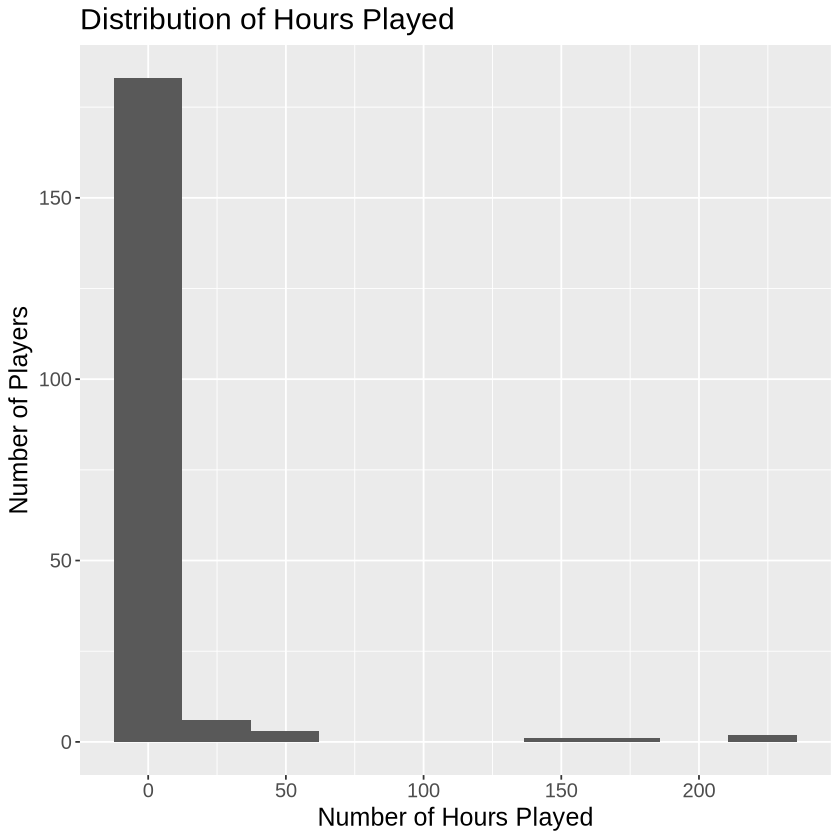

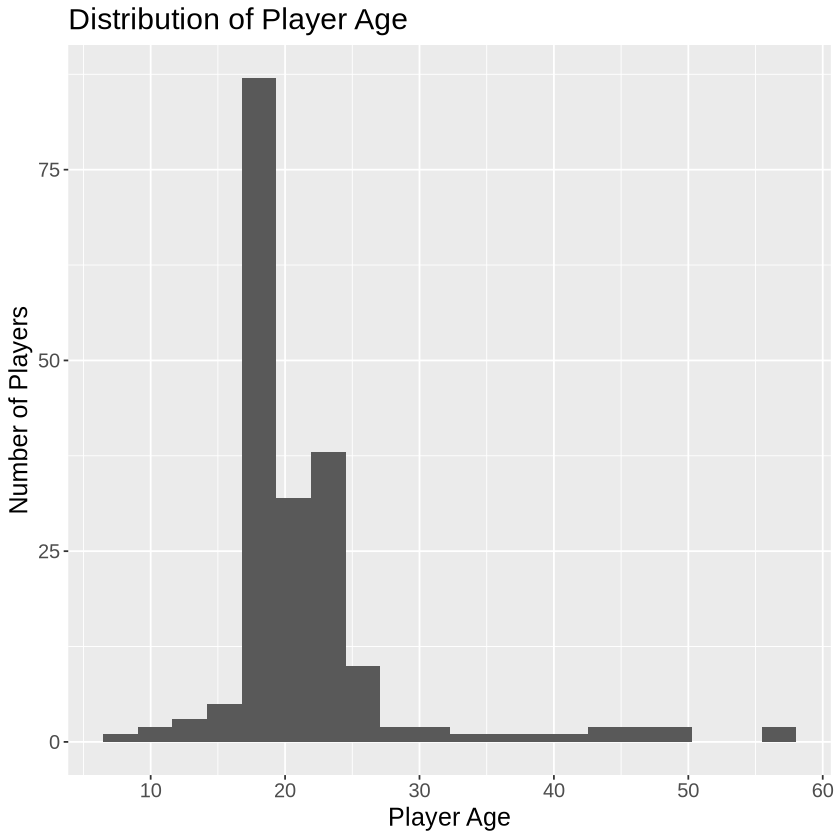

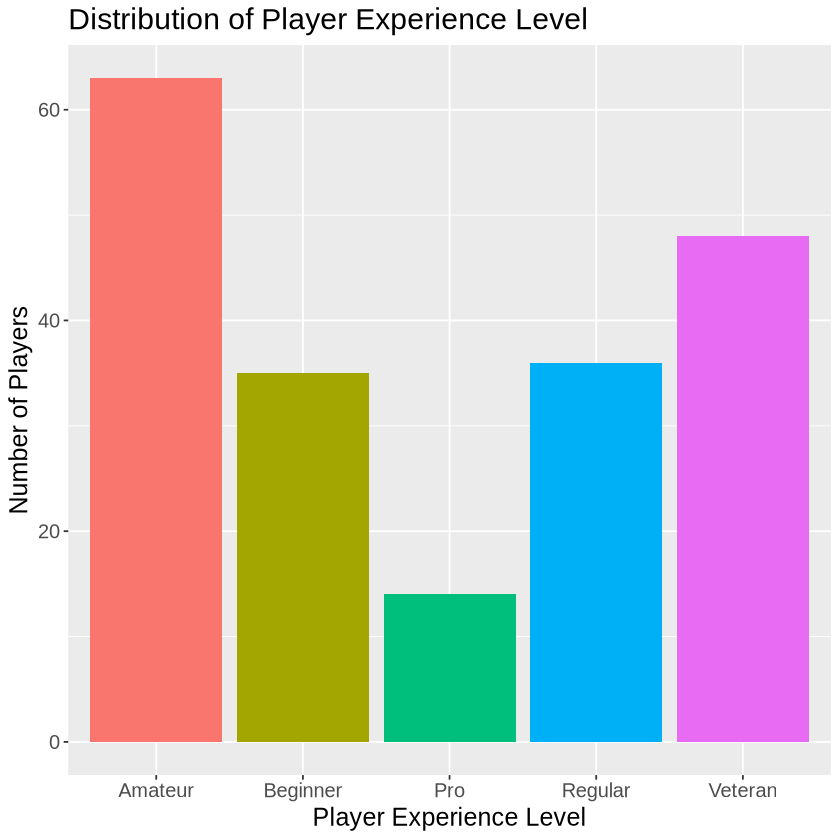

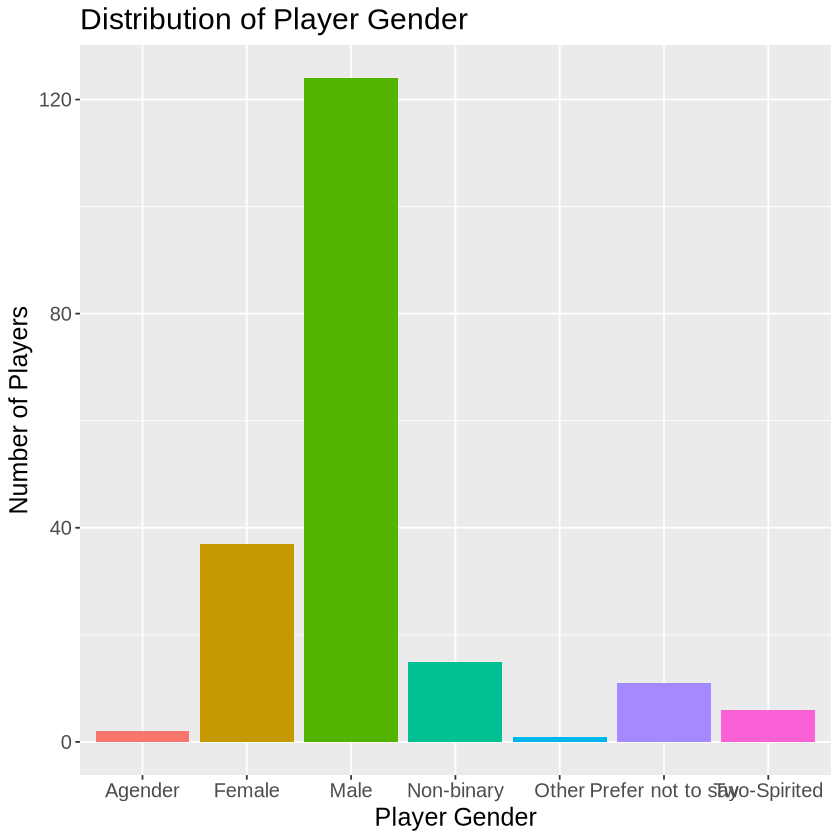

In [8]:
# create a plot showing the number of hours played and how often they show up
played_hours_plot <- tidy_players |> 
    ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 10) +
    labs(x = "Number of Hours Played", y = "Number of Players", 
         title = "Distribution of Hours Played") +
    theme(text = element_text(size = 15))
played_hours_plot

# create a plot showing the ages and how often they show up 
age_plot <- tidy_players |> 
    ggplot(aes(x = age)) +
    geom_histogram(bins = 20) +
    labs(x = "Player Age", y = "Number of Players", 
         title = "Distribution of Player Age") +
    theme(text = element_text(size = 15))
age_plot

# create a plot showing the experience levels and how often they show up
experience_plot <- tidy_players |> 
    ggplot(aes(x = experience, fill = experience)) +
    geom_bar() +
    labs(x = "Player Experience Level", y = "Number of Players", 
         title = "Distribution of Player Experience Level") +
    theme(text = element_text(size = 15),
         legend.position = "none")
experience_plot

# create a plot showing the genders and how often they show up
gender_plot <- tidy_players |> 
    ggplot(aes(x = gender, fill = gender)) +
    geom_bar() +
    labs(x = "Player Gender", y = "Number of Players", 
         title = "Distribution of Player Gender") +
    theme(text = element_text(size = 15),
         legend.position = "none")
gender_plot

### 3. Methodology 

To analyse the dataset and answer the predictive question I will be using a **K-Nearest Neighbors (KNN) classifier**. This model is appropriate because the outcome is binary, KNN works well with small datasets, does not assume linear relationships, and is able to capture similar behavioural patterns among players.

#### Assumptions 

- Meaningful distance metric: numeric variables must be scaled, so they have a similar impact on the prediction.
- Local assumption: similar players should have similar outcomes.

#### Limitations

- Potential bias if the subscription classes are imbalanced.
- Categorical predictors (experience, gender) may not fully capture similarity.
- Small sample size may make results less accurate.

#### Data processing

- Train-test split: Split the dataset before any preprocessing using a 75/25 proportion for the split.
- 75% = training data
- 25% = testing data

#### Preprocessing (recipe)

- Convert `experience` and `gender` to factors
- Scale numeric variables (`age`, `played_hours`) with `step_center()` and `step_scale()`

#### Cross-validation

- Try several values of K.
- Apply **5-fold cross-validation** within the training set to tune K and estimate performance.
- Select the K with the highest average accuracy (lowest RMSE) to avoiding overfitting.

#### Final model

- Fit the chosen KNN model on the full training set.
- Evaluate its accuracy on the 25% testing data.